# lmel modelling

### Last updated 11.5.2018

#### Preamble

In [3]:
  library(lme4)
  library(tidyverse)
  library(gamm4)
  library(mgcv)
  library(arm)
  library(stargazer)

Loading required package: Matrix
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.1     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: mgcv
Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

The following object is masked from ‘package:lme4’:

    lmList

This is mgcv 1.8-23. For overview type 'help("mgcv-package")'.
This is gamm4 0.2-5

Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select


arm (Version 1.9-3, built: 2016-11-21)

Working directory is /Users/johannesmauritzen/research/solar_prod


Pl

### Functions

In [4]:
load_data = function(){
  solar_data = read.csv("data/prod_csi.csv")
  return(solar_data)
}

In [83]:
show_production = function(solar_data){
  prod_graph =
  ggplot(solar_data, aes(x=months_operation, y=prod_scaled, group = app_num)) +
  geom_line(alpha=.01)
  return(prod_graph)
}

In [43]:
transform_log = function(solar_data){
    solar_data["log_prod_kwh"] = log(solar_data$prod_kwh+ 0.00001)
    solar_data["log_cost_per_kw"] = log(solar_data$cost_per_kw + 0.00001)
    solar_data["log_csi_rating"] = log(solar_data$csi_rating + 0.00001)
    return(solar_data)}


In [68]:
descale_data = function(solar_series){
    return((solar_series - mean(solar_series))/(2*sd(solar_series)))}


In [6]:
format_solar = function(solar_data){
  solar_data["month"] = as.factor(solar_data$month)
  solar_data = solar_data[solar_data$module_manufacturer!="Chaori", ]
  #at least three years of data
  solar_data = solar_data[solar_data$total_months_operation>=36,]
  return(solar_data)
}

In [7]:

#helper functions
extract_slopes = function(lme_model){
  #test
  #lme_model = solar_sys
  #
  slope_fe = fixef(lme_model)[13]

  slope_re=data.frame(ranef(lme_model))

  levels(slope_re$term) = c("intercept", "slope")
  #colnames(slope_re) = c("intercept", "slope")
  slopes = slope_fe + slope_re$condval[slope_re$term=="slope"]

  se_re = se.ranef(lme_model)

  if(length(se_re)>1){
    i=1
    slope_ses <- list(NA, length(se_re))

    for (name in names(se_re)){
      se_re_df=data.frame(se_re[name])
      colnames(se_re_df) = c("intercept_se", "slope_se")
      slope_ses[[i]] = se_re_df[2]
      i=i+1
    }
    slope_ses_df = do.call("rbind", slope_ses)
  } else{
    se_re_df = data.frame(se_re[1])
    colnames(se_re_df) = c("intercept_se", "slope_se")
    slope_ses_df = se_re_df[2]
  }

  slopes_df = data.frame(slopes)
  slopes_df["se"] = slope_ses_df["slope_se"]

  slopes_df["pos_ci"] = slopes_df["slopes"] + 2*slopes_df["se"]
  slopes_df["neg_ci"] = slopes_df["slopes"] - 2*slopes_df["se"]
  slopes_df["names"] = factor(row.names(slope_ses_df))

  slopes_df["grpvar"] = slope_re[slope_re$term=="slope","grpvar"]
  return(slopes_df)
}

In [8]:
order_slopes = function(slopes_df, ordervar = slopes_df$slope){
  slopes_df["names"] = factor(slopes_df$names, levels=slopes_df$names[order(ordervar)])
  return(slopes_df)
}

In [9]:
#model plotting:
slope_plot = function(slopes_df, no_xlabs=FALSE, order_slopes=TRUE, alpha=1){
  if(order_slopes){
    slopes_df = order_slopes(slopes_df)
  }
  slopes_figure = ggplot(slopes_df, aes(x=names, y=slopes)) +
    geom_errorbar(aes(ymax=pos_ci, ymin=neg_ci), alpha=alpha)
  if(no_xlabs){
    return(slopes_figure + theme(axis.ticks.x=element_blank(), axis.text.x=element_blank()))
  }else{
    return(slopes_figure+theme(axis.text = element_text(angle = 90)))
  }
}

### Modeling

In [74]:
#simple model with only lease or buy
simple_model = function(solar_data){
  solar_lme = lmer(log_prod_scaled ~ month + months_operation + (months_operation | third_party_owned), solar_data)
  return(solar_lme)
}

In [75]:
#Simple model with manufacturers
lme2_model = function(solar_data){
  solar_lme2 = lmer(log_prod_scaled ~ month + months_operation_scaled + (months_operation_scaled |module_manufacturer), solar_data)
  return(solar_lme2)
}

In [76]:
#nested model with modeling of individual systems
sys_model = function(solar_data){
  solar_sys = lmer(log_prod_scaled ~ month + months_operation_scaled + (months_operation_scaled |app_num), solar_data)
  return(solar_sys)
}

In [77]:
#also with manufacturer
nested_model = function(solar_data){
  solar_lme3 = lmer(log_prod_scaled ~ month + months_operation_scaled + (months_operation_scaled |module_manufacturer) + (months_operation_scaled|module_manufacturer:app_num), solar_data)
  return(solar_lme3)
}

In [78]:
lease_model = function(solar_data){
  solar_lme4 = lmer(log_prod_scaled ~ month + months_operation_scaled + (months_operation_scaled |third_party_owned) + (months_operation_scaled|third_party_owned:app_num), solar_data)
  return(solar_lme4)
}

In [79]:
lease_model2 = function(solar_data){
  #test if prices are more correlated with
  solar_lme4 = lmer(log_prod_scaled ~ month + months_operation_scaled*third_party_owned + (months_operation_scaled*third_party_owned|app_num), solar_data)
  return(solar_lme4)
}

In [80]:
#useing GAM from GAMM4
gamm_model_man = function(solar_data){

  solar_data["month"] = as.numeric(as.character(solar_data$month))
  solar_gamm4 = gamm4(log_prod_scaled ~ s(month) + months_operation_scaled, dat=solar_data, random=~(months_operation_scaled|module_manufacturer))
  return(solar_gamm4)

}

### Analysis

In [35]:
solar_data = load_data()

In [36]:
head(solar_data)

app_num,prog_admin,program_x,tot_cost,own_sect,host_cust_sect,cust_city,cust_county,cust_zip,pbi_payment_num,⋯,months_operation,total_months_operation,month,year,first_prod_year,cap_util,cost_per_kw,cost_per_kw_scaled,months_operation_scaled,first_prod_year_scaled
SD-CSI-00001,CSE,Large Commercial (>= 10 kW),1536640,Commercial,Commercial,San Diego,San Diego,92121,1,⋯,1,60,5,2007,2007,0.4696525,7102.826,0.05321379,-0.7813138,-1.12037
SD-CSI-00001,CSE,Large Commercial (>= 10 kW),1536640,Commercial,Commercial,San Diego,San Diego,92121,2,⋯,2,60,6,2007,2007,0.5303203,7102.826,0.05321379,-0.7511442,-1.12037
SD-CSI-00001,CSE,Large Commercial (>= 10 kW),1536640,Commercial,Commercial,San Diego,San Diego,92121,3,⋯,3,60,7,2007,2007,0.4894000,7102.826,0.05321379,-0.7209746,-1.12037
SD-CSI-00001,CSE,Large Commercial (>= 10 kW),1536640,Commercial,Commercial,San Diego,San Diego,92121,4,⋯,4,60,8,2007,2007,0.4525114,7102.826,0.05321379,-0.6908050,-1.12037
SD-CSI-00001,CSE,Large Commercial (>= 10 kW),1536640,Commercial,Commercial,San Diego,San Diego,92121,5,⋯,5,60,9,2007,2007,0.4640672,7102.826,0.05321379,-0.6606355,-1.12037
SD-CSI-00001,CSE,Large Commercial (>= 10 kW),1536640,Commercial,Commercial,San Diego,San Diego,92121,6,⋯,6,60,10,2007,2007,0.3674609,7102.826,0.05321379,-0.6304659,-1.12037


In [45]:
solar_data = transform_log(solar_data)

In [47]:
head(solar_data)

app_num,prog_admin,program_x,tot_cost,own_sect,host_cust_sect,cust_city,cust_county,cust_zip,pbi_payment_num,⋯,year,first_prod_year,cap_util,cost_per_kw,cost_per_kw_scaled,months_operation_scaled,first_prod_year_scaled,log_prod_kwh,log_cost_per_kw,log_csi_rating
SD-CSI-00001,CSE,Large Commercial (>= 10 kW),1536640,Commercial,Commercial,San Diego,San Diego,92121,1,⋯,2007,2007,0.4696525,7102.826,0.05321379,-0.7813138,-1.12037,10.50720,8.868248,5.376861
SD-CSI-00001,CSE,Large Commercial (>= 10 kW),1536640,Commercial,Commercial,San Diego,San Diego,92121,2,⋯,2007,2007,0.5303203,7102.826,0.05321379,-0.7511442,-1.12037,10.62869,8.868248,5.376861
SD-CSI-00001,CSE,Large Commercial (>= 10 kW),1536640,Commercial,Commercial,San Diego,San Diego,92121,3,⋯,2007,2007,0.4894000,7102.826,0.05321379,-0.7209746,-1.12037,10.54839,8.868248,5.376861
SD-CSI-00001,CSE,Large Commercial (>= 10 kW),1536640,Commercial,Commercial,San Diego,San Diego,92121,4,⋯,2007,2007,0.4525114,7102.826,0.05321379,-0.6908050,-1.12037,10.47002,8.868248,5.376861
SD-CSI-00001,CSE,Large Commercial (>= 10 kW),1536640,Commercial,Commercial,San Diego,San Diego,92121,5,⋯,2007,2007,0.4640672,7102.826,0.05321379,-0.6606355,-1.12037,10.49524,8.868248,5.376861
SD-CSI-00001,CSE,Large Commercial (>= 10 kW),1536640,Commercial,Commercial,San Diego,San Diego,92121,6,⋯,2007,2007,0.3674609,7102.826,0.05321379,-0.6304659,-1.12037,10.26183,8.868248,5.376861


In [69]:
solar_data["log_prod_scaled"] = descale_data(solar_data$log_prod_kwh)


In [70]:
solar_data["log_cost_scaled"] = descale_data(solar_data$log_cost_per_kw)

In [71]:
solar_data["log_csi_rating_scaled"] = descale_data(solar_data$log_csi_rating)

In [84]:

  solar_data = format_solar(solar_data)
  prod_fig = show_production(solar_data)

  lm_model = lm(prod_scaled~months_operation, data=solar_data)
  lm_coef = coef(lm_model)

  prod_fig = prod_fig + geom_abline(intercept=lm_coef[1], slope=lm_coef[2], color="red") + xlim(0,60) + ylim(-1.5,1.5) + labs(x="months",y="Production, de-scaled")

  ggsave("figures/production.png", plot=prod_fig, dpi=100,width = 9, height = 5)



Warning message:
“Removed 51 rows containing missing values (geom_path).”

Warning message:
“Removed 51 rows containing missing values (geom_path).”

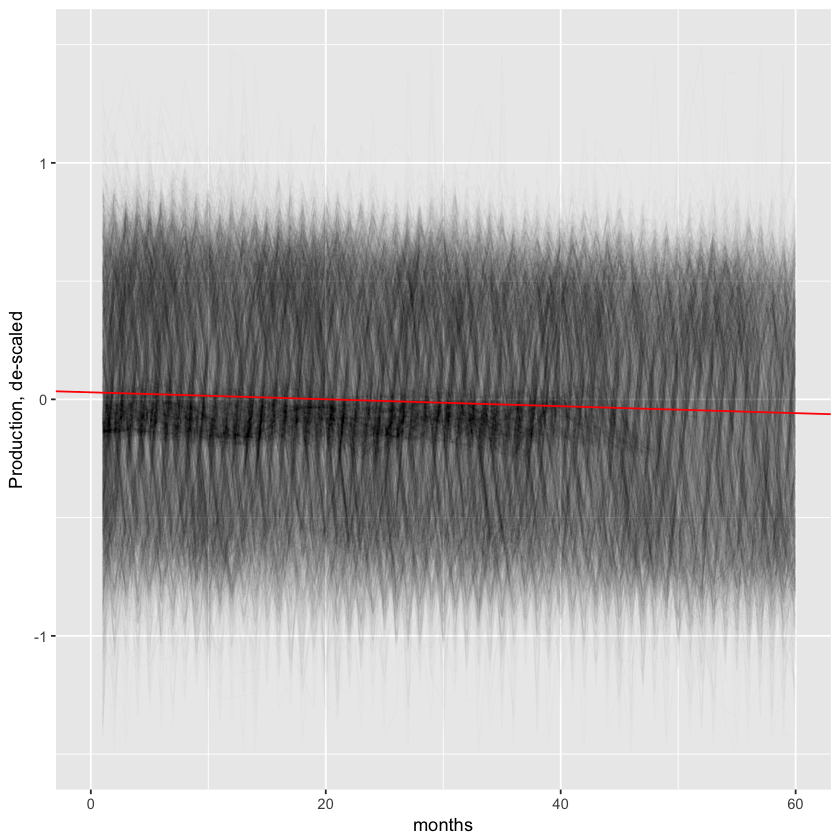

In [85]:
prod_fig

In [86]:
  table(solar_data["third_party_owned"])


    no    yes 
111919  59108 

In [87]:
  59108/(111919+59108)

[1] 0.3456062

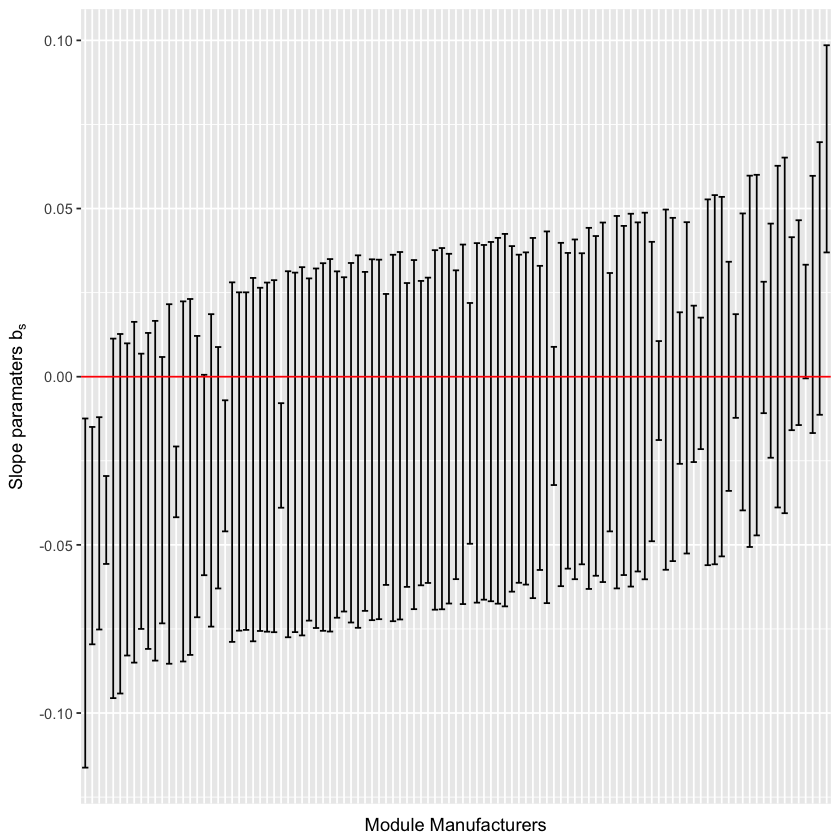

In [115]:
#model with manufacturers
  solar_lme2 = lme2_model(solar_data)
  slopes_df_man = extract_slopes(solar_lme2)
  man_fig = slope_plot(slopes_df_man, no_xlabs=TRUE)
  man_fig_final = man_fig + geom_hline(yintercept=0, color="red") + labs(x="Module Manufacturers", y=expression(paste("Slope paramaters ", b[s])))
  man_fig_final
  ggsave("figures/manufacturer_slope.png", plot=man_fig_final, dpi=300, width = 10, height = 5)


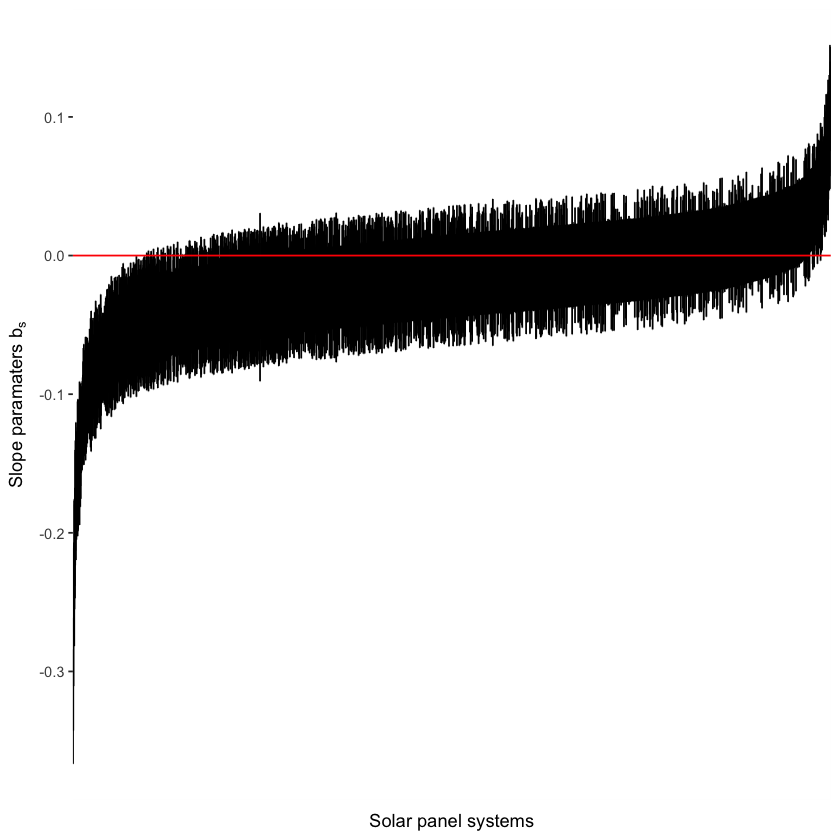

In [114]:
  #model with systems
  solar_sys = sys_model(solar_data)
  slopes_df_sys = extract_slopes(solar_sys)
  sys_slope_fig = slope_plot(slopes_df_sys, no_xlabs=TRUE)
  sys_slope_fig_final = sys_slope_fig + geom_hline(yintercept=0, color="red") + labs(x="Solar panel systems", y=expression(paste("Slope paramaters ", b[s])))
  sys_slope_fig_final
  ggsave("figures/sys_slope_fig.png", plot=sys_slope_fig_final, dpi=300, width = 9, height = 5)


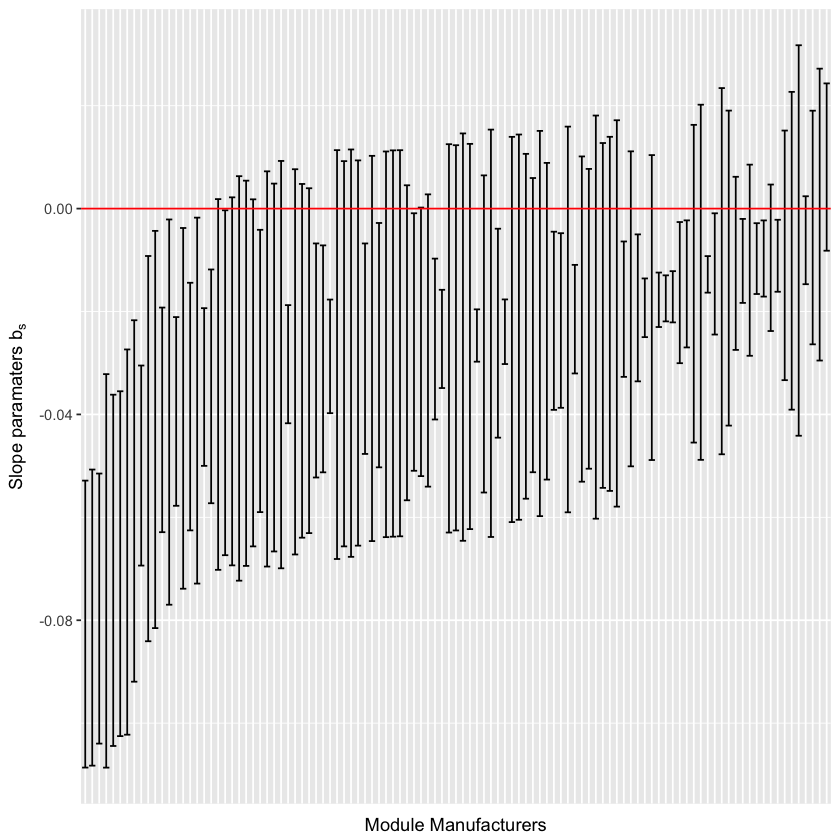

In [113]:
  #nested model with manufacturer and system
  solar_nested = nested_model(solar_data)
  slopes_df_nest = extract_slopes(solar_nested)
  nested_manuf_fig = slope_plot(slopes_df_nest[slopes_df_nest$grpvar=="module_manufacturer", ], no_xlabs=TRUE)
  nested_manuf_fig_final = nested_manuf_fig + geom_hline(yintercept=0, color="red") + labs(x="Module Manufacturers", y=expression(paste("Slope paramaters ", b[s])))
  nested_manuf_fig_final

  ggsave("figures/nested_manuf_fig_final.png", plot=nested_manuf_fig_final, dpi=300, width = 9, height = 5)



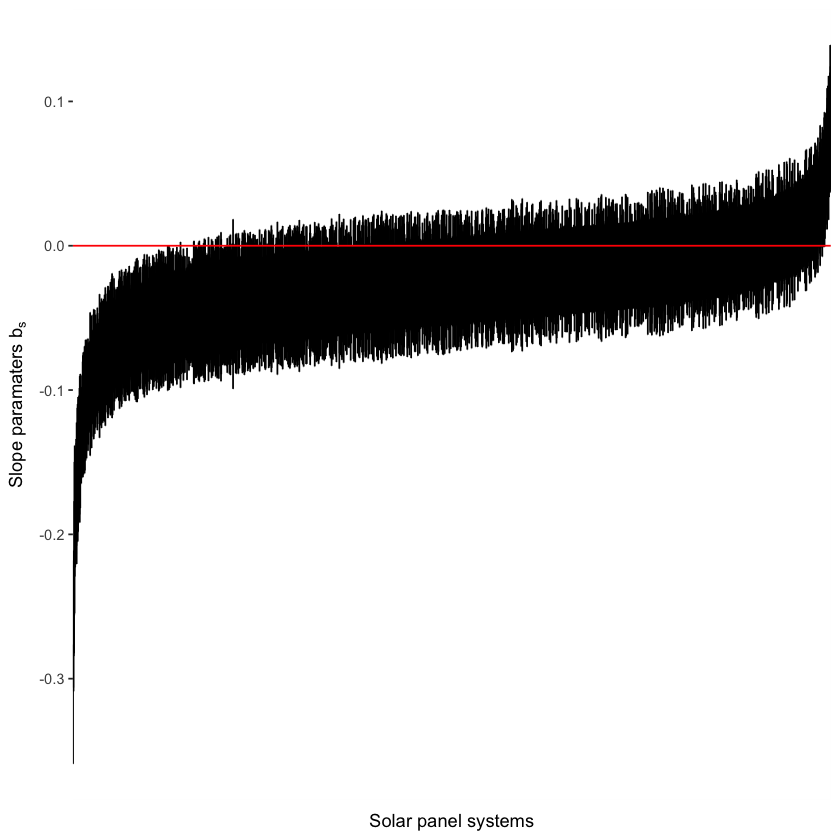

In [112]:
  nested_sys_fig = slope_plot(slopes_df_nest[slopes_df_nest$grpvar=="module_manufacturer:app_num", ], no_xlabs=TRUE)

  nested_sys_fig_final = nested_sys_fig + geom_hline(yintercept=0, color="red") + labs(x="Solar panel systems", y=expression(paste("Slope paramaters ", b[s])))

  nested_sys_fig_final

  ggsave("figures/nested_sys_fig.png", plot=nested_sys_fig_final, dpi=100, width = 9, height = 5)


In [92]:
#Now model also with lease no lease:

  solar_lease = lease_model(solar_data)

  slopes_df_lease = extract_slopes(solar_lease)

  slopes_df_lease["names"]= as.character(slopes_df_lease$names)

  slopes_df_lease = slopes_df_lease %>% separate(names, c("third_party_owned", "names"), sep=":")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00277948 (tol = 0.002, component 1)”Warning message:
“Too few values at 2 locations: 3146, 3147”

In [93]:
  #manually change ordering:
  slopes_df_lease["names"] = factor(slopes_df_lease$names, levels=slopes_df_lease$names[order(slopes_df_lease$third_party_owned, slopes_df_lease$slopes)])

  leased_re_slopes = slopes_df_lease[slopes_df_lease$grpvar=="third_party_owned",]
  leased_re_slopes


,slopes,se,pos_ci,neg_ci,third_party_owned,names,grpvar
3146,-0.02013390,0.0001877382,-0.01975842,-0.02050937,no,NA,third_party_owned
3147,-0.01377067,0.0002584753,-0.01325372,-0.01428762,yes,NA,third_party_owned


In [94]:
  #magnitude
  .0405 - .0256

[1] 0.0149

In [95]:
slopes_df_lease =  slopes_df_lease[slopes_df_lease$grpvar=="third_party_owned:app_num",]

  re_slopes_list = list("no" = leased_re_slopes$slopes[leased_re_slopes$third_party_owned=="no"],
  "yes" = leased_re_slopes$slopes[leased_re_slopes$third_party_owned=="yes"]
)

  re_se_list = list("no" = leased_re_slopes$se[leased_re_slopes$third_party_owned=="no"],
  "yes" = leased_re_slopes$se[leased_re_slopes$third_party_owned=="yes"]
  )

  slopes_df_lease["leased_re"] =  unlist(re_slopes_list[slopes_df_lease$third_party_owned])

  slopes_df_lease["leased_re_se"] =  unlist(re_se_list[slopes_df_lease$third_party_owned])
  slopes_df_lease["third_party_owned"] = factor(slopes_df_lease$third_party_owned)
  slopes_df_lease["re_ci_plus"] = slopes_df_lease["leased_re"] + 2* slopes_df_lease["leased_re_se"]
  slopes_df_lease["re_ci_minus"] = slopes_df_lease["leased_re"] - 2* slopes_df_lease["leased_re_se"]


In [110]:
  lease_sys_fig = slope_plot(slopes_df_lease, order_slopes=FALSE,  no_xlabs=TRUE, alpha=.1)

  lease_sys_fig_final = lease_sys_fig +
  geom_line(aes(x=names, y=leased_re, linetype=third_party_owned, group=third_party_owned)) +
  geom_ribbon(aes(ymin=re_ci_minus, ymax=re_ci_plus, group=third_party_owned) ,alpha=.5) +
  geom_hline(yintercept=0, color="red") + labs(x="Solar panel systems", y=expression(paste("Slope paramaters ", b[s])), linetype="Leased")

  ggsave("figures/lease_sys_fig.png", plot=lease_sys_fig_final, dpi=300, width = 9, height = 5)


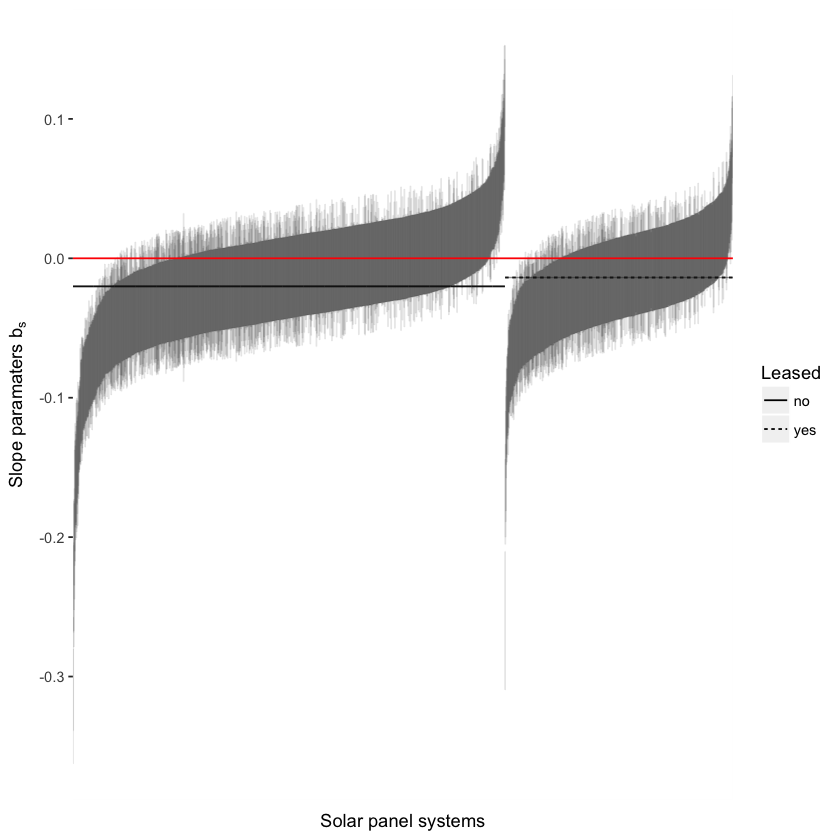

In [111]:
lease_sys_fig_final

In [31]:
#leased as an interaction effect.
  solar_lease2 = lease_model2(solar_data)
  slopes_df_lease2 = extract_slopes(solar_lease2)
  slopes_df_lease2["names"]= as.character(slopes_df_lease2$names)

  slopes_df_lease2 = slopes_df_lease %>% separate(names, c("third_party_owned", "names"), sep=":")

  #manually change ordering:
  slopes_df_lease2["names"] = factor(slopes_df_lease2$names, levels=slopes_df_lease2$names[order(slopes_df_lease2$third_party_owned, slopes_df_lease2$slopes)])



Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”

ERROR: Error in `levels<-.factor`(`*tmp*`, value = c("intercept", "slope")): number of levels differs


In [ ]:
  #table results of nested and non-nested
  stargazer(solar_sys, solar_nested)
  #Compare AIC scores and anova

  AIC(solar_sys, solar_nested, solar_lease)

  anova_results = anova(solar_sys, solar_nested, solar_lease)
  anova_results

  stargazer(anova_results)

  anova(solar_nested)